In [1]:
import os
import numpy as np
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import earthpy as et
import imageio
from datetime import datetime

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors
import cv2
from matplotlib.colors import hsv_to_rgb
import geojson
from pyproj import Proj
UTM_10_PROJ = Proj("+proj=utm +zone=10N, +north +ellps=WGS84 +datum=WGS84 +units=m +no_defs")


(10000, 10000, 3) uint8


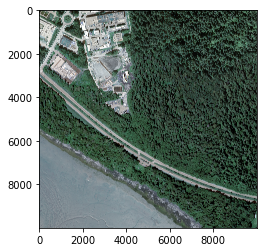

In [2]:
os.chdir(os.path.join(et.io.HOME, "ubc/capstone/orthophoto/2014"))
image = cv2.imread('483E_5454N.tif')
type(image)
print(image.shape, image.dtype)
plt.imshow(image)
nemo = image[:5000, :5000, :]
hsv_nemo = cv2.cvtColor(nemo[:5000,:5000,:], cv2.COLOR_RGB2HSV)

[[127 255 150]
 [127 255 150]
 [127 255 150]
 [127 255 150]
 [127 255 150]
 [127 255 150]
 [127 255 150]
 [127 255 150]
 [127 255 150]
 [127 255 150]]
[[ 35   0 150]
 [ 35   0 150]
 [ 35   0 150]
 [ 35   0 150]
 [ 35   0 150]
 [ 35   0 150]
 [ 35   0 150]
 [ 35   0 150]
 [ 35   0 150]
 [ 35   0 150]]


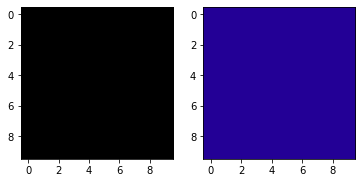

In [3]:
dark_green = (55/360*255,0, 0)
light_green = (180/360*255, 255, 150)
lo_square = np.full((10, 10, 3), light_green, dtype=np.uint8)
print(lo_square[0])
do_square = np.full((10, 10, 3), dark_green, dtype=np.uint8)
plt.subplot(1, 2, 1)
lo_square = cv2.cvtColor(lo_square, cv2.COLOR_HSV2RGB)
print(lo_square[0])
do_square = cv2.cvtColor(do_square, cv2.COLOR_HSV2RGB)
plt.imshow(do_square)
plt.subplot(1, 2, 2)
plt.imshow(lo_square)
plt.show()

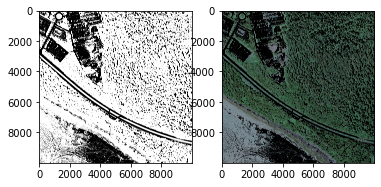

0:00:05.545864


In [4]:
kernel = np.ones((5,5),np.float32)/25
blurred_image = cv2.filter2D(image,-1,kernel)
startTime = datetime.now()
nemo = blurred_image
hsv_nemo = cv2.cvtColor(nemo, cv2.COLOR_RGB2HSV)
mask = cv2.inRange(hsv_nemo, dark_green, light_green)
result = cv2.bitwise_and(nemo, nemo, mask=mask)
plt.subplot(1, 2, 1)
plt.imshow(mask, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(result)
plt.show()
print(datetime.now() - startTime)

0:25:42.551199


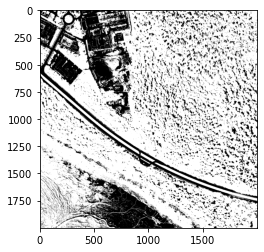

In [24]:
def compressed_green(x,y,window_size,green_mask):
    r = green_mask[x*window_size:(x+1)*window_size, y*window_size:(y+1)*window_size]
    return r.mean() > 128
n = 2000
compressed_green_array = np.array([compressed_green(i//n,i%n,5,mask) for i in range(0,n**2)]).reshape(n,n)
plt.imshow(compressed_green_array, cmap=plt.cm.gray)
print(datetime.now() - startTime)

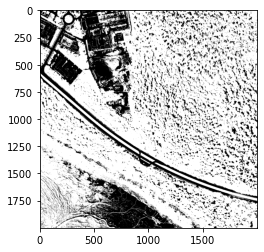

In [25]:
n=2000
green_array = np.array([compressed_green_array[i//n,i%n] for i in range(0,n**2)]).reshape(n,n)
plt.imsave("green.png", green_array)
plt.imshow(green_array,cmap=plt.cm.gray)

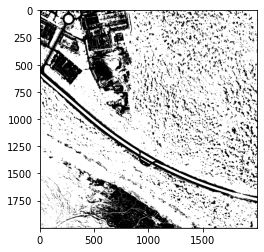

In [26]:
close_img = ndimage.binary_closing(green_array)
plt.imshow(close_img, cmap=plt.cm.gray)

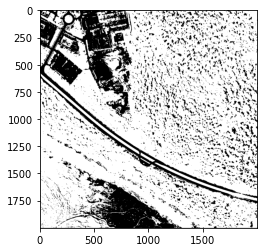

In [27]:
open_img = ndimage.binary_opening(close_img)
plt.imshow(open_img, cmap=plt.cm.gray)
plt.imsave("green.png", open_img)


In [28]:
im = cv2.imread('green.png')
imgray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
ret,thresh = cv2.threshold(imgray,127,255,0)

In [29]:
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [30]:
len(contours   )

744

In [31]:
def convert_to_lon_lat(polygon_10_m, utm_10_bot_left_coord):
    polygon_10_m = polygon_10_m/ 10
    polygon_10_m = [[x[0][0]+utm_10_bot_left_coord[0],1000-x[0][1]+utm_10_bot_left_coord[1]] for x in polygon_10_m]
    projected = [UTM_10_PROJ(x[0], x[1], inverse=True) for x in polygon_10_m]
    head = projected[0]
    projected.append(head)
    return projected
lon_lat = convert_to_lon_lat(contours[0]*20,[483000,5454000])
lon_lat

[(-123.2046901423394, 49.21168145756974),
 (-123.20471752831224, 49.21166341844971),
 (-123.20468999378697, 49.21164547665959),
 (-123.20466260781399, 49.21166351577316),
 (-123.2046901423394, 49.21168145756974)]

In [32]:
feature_list = []
for c in contours:
    lon_lat = convert_to_lon_lat(c*5,[483000,5454000])
    feature_list.append(geojson.Feature(geometry=geojson.Polygon([lon_lat])))
feature_collection = geojson.FeatureCollection(feature_list)

with open("polygons.geojson", mode = "w") as out_file:
    geojson.dump(feature_collection,out_file)
